This jupyter notebook contains some of the codes and calculations associated with our recent paper: 

**"The VLT-MUSE and ALMA view of the MACS 1931.8-2635 brightest cluster galaxy"** 

Ciocan B. I. , Ziegler, B. L. , Verdugo, M. , Papaderos, P. , Fogarty, K. , Donahue, M. , and Postman, M.

## Making Velocity Ratio maps between H$\alpha$ and CO from MUSE and ALMA data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table,join
from astropy.wcs import WCS
from astropy import units as u
from astropy.modeling.models import Gaussian2D
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.stats import gaussian_kde
from mpdaf.obj import Image, Spectrum
import pyregion
from reproject import reproject_interp
import os

In [2]:
data_dir = "/Users/biancaciocan/Documents/M1931_BCG_PROJECT/M1931_results_FADO_python/"
muse_file = "Ha_velocity_map_fin_wcsshift.fits"
alma_file = "CO32_Velocity.fits"

museHDU = fits.open(os.path.join(data_dir, muse_file))
almaHDU = fits.open(os.path.join(data_dir, alma_file))

print(museHDU.info(), almaHDU.info())

Filename: /Users/biancaciocan/Documents/M1931_BCG_PROJECT/M1931_results_FADO_python/Ha_velocity_map_fin_wcsshift.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      30   (90, 90)   float64   
Filename: /Users/biancaciocan/Documents/M1931_BCG_PROJECT/M1931_results_FADO_python/CO32_Velocity.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     732   (800, 800, 1, 1)   float64   
None None


There are 4 ALMA WCS axes, including the 2 for frequency and polarization.
We need to drop those 2 extra  WCS axes in order to match the MUSE data.

In [3]:
w_alma = WCS(almaHDU[0])
print(w_alma)
w_muse = WCS(museHDU[0])
print(w_muse)
alma_3wcs = w_alma.dropaxis(3)
alma_2wcs = alma_3wcs.dropaxis(2)
print(alma_2wcs)

#now make a new header for ALMA data
newalmaHeader = alma_2wcs.to_header()
data = almaHDU[0].data
header = newalmaHeader
data2 = data[0][0] 
header.set("NAXIS", value=2)
newhdu = fits.PrimaryHDU(data=data2, header=header) 
newhdu.writeto("CO32_Velocity_2wcs.fits", overwrite=True)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 292.9566667001  -26.57611110001  1.0  256181514856.0  
CRPIX : 401.0  401.0  1.0  -6.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -2.083333333333e-05  2.083333333333e-05  1.0  -21320568.14618  
NAXIS : 800  800  1  1
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 292.957299  -26.57665  
CRPIX : 30.495203706938  32.26065625034001  
CD1_1 CD1_2  : -5.55555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555556e-05  
NAXIS : 90  90
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 292.9566667001  -26.57611110001  
CRPIX : 401.0  401.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -2.083333333333e-05  2.083333333333e-05  
NAXIS : 800  800


Filename: CO32_Velocity_2wcs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (800, 800)   float64   
None
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  800                                                  
NAXIS2  =                  800                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                401.0 / Pixel coordinate of reference point            
CRPIX2  =                401.0 / Pixel coordinate of reference point            
CDELT1  =  -2.083333333333E-05 / [deg] Coordinate increment at reference point  
CDELT2  =   2.083333333333E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'        

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Text(0.5, 1.0, 'ALMA')

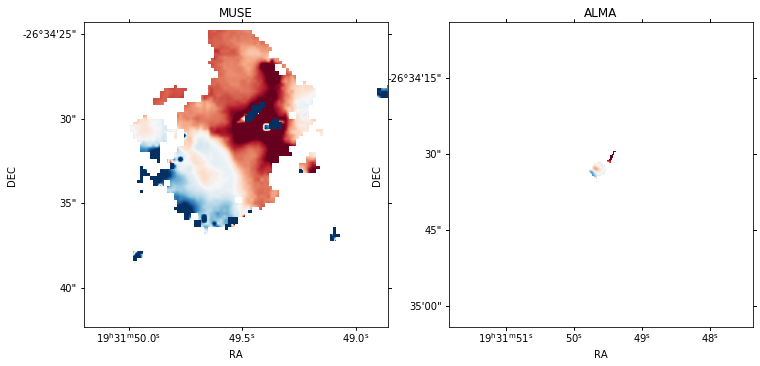

In [4]:
#plot the 2 images

almaHDU_new = fits.open("CO32_Velocity_2wcs.fits")
print(almaHDU_new.info())
print(repr(almaHDU_new[0].header))



ax=plt.figure(figsize=(12,12))
cm = plt.cm.get_cmap('RdBu_r')


ax1 = plt.subplot(1,2,1, projection=WCS(museHDU[0].header))
ax1.imshow(museHDU[0].data, origin='lower', vmin=-400, vmax=400, cmap=cm, interpolation='bilinear')
ax1.coords['ra'].set_axislabel('RA')
ax1.coords['dec'].set_axislabel('DEC')
ax1.set_title('MUSE')

ax2 = plt.subplot(1,2,2, projection=WCS(almaHDU_new[0].header))
ax2.imshow(almaHDU_new[0].data, origin='lower',  vmin=-300, vmax=300, cmap=cm, interpolation='bilinear')
ax2.coords['ra'].set_axislabel('RA')
ax2.coords['dec'].set_axislabel('DEC')
ax2.set_title('ALMA')

Now we need to downgrade the resolution of the MUSE data to match that of the ALMA data using astropy

In [5]:

ALMA_data = almaHDU_new[0].data
MUSE_data = museHDU[0].data

from astropy.modeling.models import Gaussian2D
from astropy.convolution import convolve, Gaussian2DKernel 

#seeing of MUSE is 0.8" FWHM; need sigma value; FWHM=2.355*sigma => sigma=FWHM/2.355
FWHM_MUSE = 0.8 
sigma1 = FWHM_MUSE / 2.355
#convert to pixel units
sigma1_px = sigma1 / 0.2 #MUSE pixel scale

# CO(3-2) from ALMA Band 6 - minimum possible synthesized beam 0.74"
FWHM_ALMA = 0.74
sigma2 = FWHM_ALMA / 2.355 
#convert to pixel units
sigma2_px = sigma2 / 0.2 # BECAUSE we are working on MUSE


#for EllipticalGaussian2DKernel 
from radio_beam import EllipticalGaussian2DKernel
kernel_size = np.sqrt(sigma1_px**2 - sigma2_px**2)
kernel = EllipticalGaussian2DKernel(stddev_maj=kernel_size, stddev_min=kernel_size, position_angle=74.862)


###for normal  Gaussian2DKernel 
#kernel_size = np.sqrt(sigma2_px**2 - sigma1_px**2)
#kernel = Gaussian2DKernel(x_stddev=kernel_size, y_stddev=kernel_size)

conv_MUSE = convolve(MUSE_data, kernel)

fits.writeto('Ha_velocity_map_fin_wcsshift_convolved.fits', conv_MUSE, museHDU[0].header, overwrite=True)   


Now we need to resample the ALMA data onto the MUSE data pixel grids. We do this using the astropy reproject task. This function resamples the data to a new projection using interpolation and it essentially tells the user which pixels in the new image had a corresponding pixel in the old image.

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Text(7.5, 6, '10 kpc')

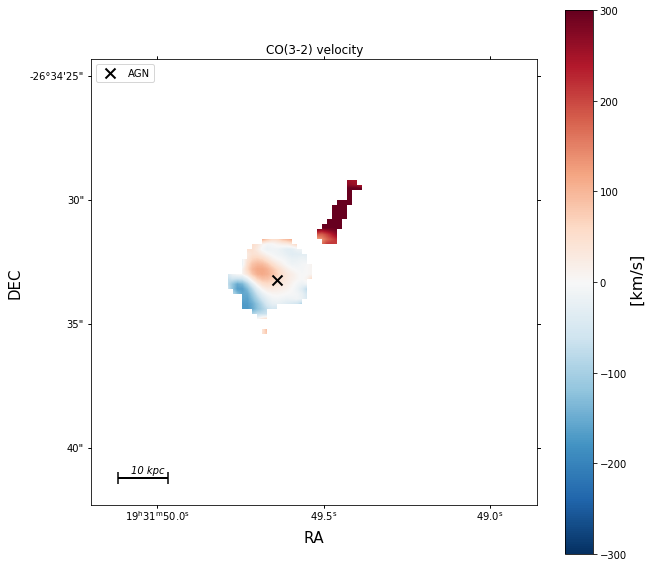

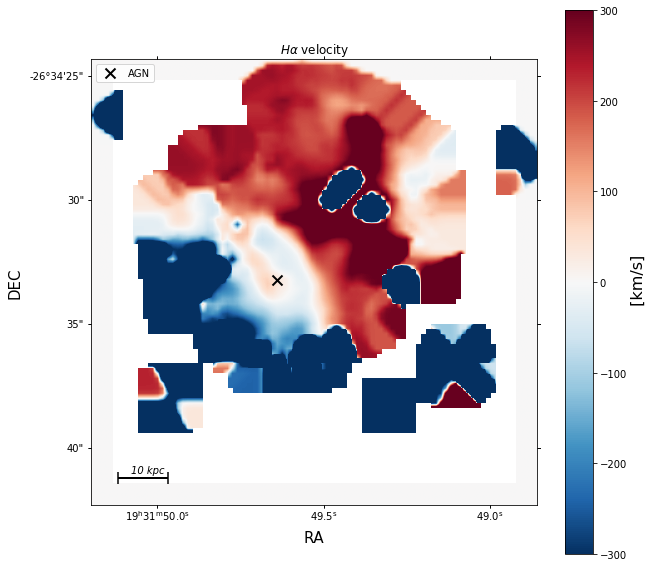

In [6]:
registered_alma_data, registered_alma_footprint = reproject_interp(almaHDU_new, museHDU[0].header)
registered_alma_data[registered_alma_data==0] = np.nan
fits.writeto('CO32_Velocity_2wcs_reprojected_image.fits', registered_alma_data,museHDU[0].header, overwrite=True)   

#load the 2 images again
muse = fits.open('Ha_velocity_map_fin_wcsshift_convolved.fits')
alma = fits.open('CO32_Velocity_2wcs_reprojected_image.fits')   

#plot them
cm = plt.cm.get_cmap('RdBu_r')
header = alma[0].header
wcs = WCS(header)
p_center = 37
q_center = 45

plt.figure(figsize=(10,10))
plt.subplot(projection=wcs)

ax = plt.imshow(alma[0].data,vmin=-300, vmax=300, origin="lower", cmap=cm, interpolation="bilinear")
cbar = plt.colorbar(ax)
cbar.set_label(r" [km/s]", fontsize=16)
plt.title(r'CO(3-2) velocity')
plt.xlabel("RA")
plt.ylabel("DEC")

agn = plt.scatter(p_center,q_center, marker='x',color='black',linewidth=2, s=100,label='AGN')
plt.legend(handles=[agn], loc="upper left")
plt.xlabel("RA", fontsize=15)
plt.ylabel("DEC", fontsize=15)
plt.hlines(y=5, xmin=5, xmax=15, linewidth=2, color='black')
plt.scatter(5,5, marker=2, color='black')
plt.scatter(5,5, marker=3, color='black')
plt.scatter(15,5, marker=2, color='black')
plt.scatter(15,5, marker=3, color='black')
plt.text(7.5, 6, '10 kpc', style='italic')


cm = plt.cm.get_cmap('RdBu_r')
header = muse[0].header
wcs = WCS(header)
plt.figure(figsize=(10,10))
plt.subplot(projection=wcs)
ax = plt.imshow(muse[0].data, vmin=-300, vmax=300, origin="lower", cmap=cm, interpolation="bilinear")
cbar = plt.colorbar(ax)
cbar.set_label(r" [km/s]", fontsize=16)
plt.title(r'$H\alpha$ velocity')
plt.xlabel("RA")
plt.ylabel("DEC")

agn = plt.scatter(p_center,q_center, marker='x',color='black',linewidth=2, s=100,label='AGN')

plt.legend(handles=[agn], loc="upper left")
plt.xlabel("RA", fontsize=15)
plt.ylabel("DEC", fontsize=15)
plt.hlines(y=5, xmin=5, xmax=15, linewidth=2, color='black')
plt.scatter(5,5, marker=2, color='black')
plt.scatter(5,5, marker=3, color='black')
plt.scatter(15,5, marker=2, color='black')
plt.scatter(15,5, marker=3, color='black')
plt.text(7.5, 6, '10 kpc', style='italic')


Calculate the difference between the velocities of Ha and CO gas

Text(7.5, 6, '10 kpc')

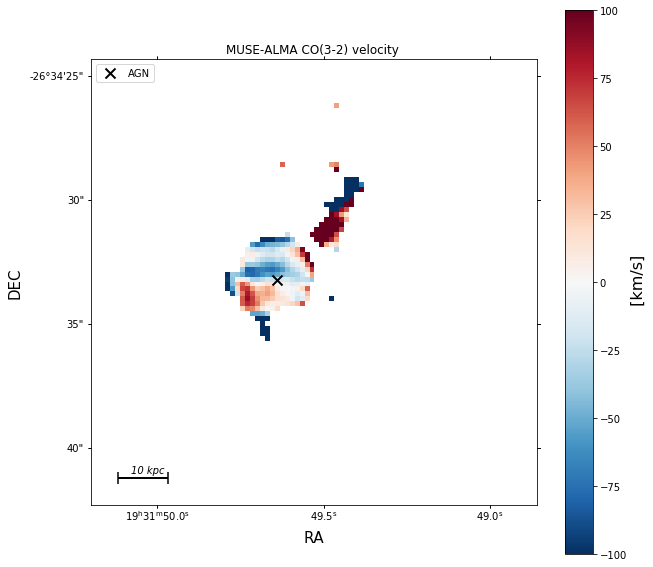

In [7]:
dif = muse[0].data - alma[0].data

# or if this were to be the velocity dispersion: ratio =muse[0].data/alma[0].data

newhdu = fits.PrimaryHDU(data=dif, header=muse[0].header) 
newhdu.writeto("alma_muse_CO32_vel_dif.fits", overwrite=True)

# here an example using mpdaf.Image (and not astropy fits and how to plot it with matplotlib)  
dif_Img = Image("alma_muse_CO32_vel_dif.fits")


plt.figure(figsize=(10,10))
cm = plt.cm.get_cmap('RdBu_r')
ax = dif_Img.plot(use_wcs=True, cmap=cm, vmin=-100, vmax=100) # different cmap scale
cbar = plt.colorbar(ax)
plt.title("MUSE-ALMA CO(3-2) velocity ")
cbar.set_label(r" [km/s]", fontsize=16)
agn = plt.scatter(p_center,q_center, marker='x',color='black',linewidth=2, s=100,label='AGN')
plt.legend(handles=[agn], loc="upper left")
plt.xlabel("RA", fontsize=15)
plt.ylabel("DEC", fontsize=15)
plt.hlines(y=5, xmin=5, xmax=15, linewidth=2, color='black')
plt.scatter(5,5, marker=2, color='black')
plt.scatter(5,5, marker=3, color='black')
plt.scatter(15,5, marker=2, color='black')
plt.scatter(15,5, marker=3, color='black')
plt.text(7.5, 6, '10 kpc', style='italic')



Do the same for all the other maps :) 